<a href="https://colab.research.google.com/github/mohiiieldin/Covid-Classifier-from-Chest-X-Ray/blob/main/Covid_19_Classifier_from_Chest_X_Ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
import os
import numpy as np
import cv2                 
from random import shuffle
from tqdm import tqdm  
import tensorflow as tf 
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
from collections import Counter
import shutil
import random
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Use the next 2 functions when needed only:

In [ ]:
def concat_source_dest(source,destination ,class_names) :
  """
  Use this function to add images directories from one folder to another, i use it to concat the whole data set again if i want
  """
  for c in class_names:
          images = [x for x in os.listdir(os.path.join(source, c)) if x.lower().endswith('png')]
          for image in images:
              source_path = os.path.join(source, c, image)
              target_path = os.path.join(destination, c, image)
              shutil.move(source_path, target_path)

In [ ]:
def seperate_source_dest(source_dir , destination_dir ,class_names , p) :
  """
  Use this function to move images directories from one folder to another, i use it to seprate the data set into train, validation and test
  """
  for c in class_names:
        images = [x for x in os.listdir(os.path.join(source_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, int(p * len(images)))
        for image in selected_images:
            source_path = os.path.join(source_dir, c, image)
            target_path = os.path.join(destination_dir,c, image)
            shutil.move(source_path, target_path)

In [ ]:
train_dir = "/content/drive/MyDrive/COVID-19 Radiography Database/train"
val_dir = "/content/drive/MyDrive/COVID-19 Radiography Database/val"
test_dir = "/content/drive/MyDrive/COVID-19 Radiography Database/test" 
class_names = ['covid' , 'normal', 'viral']

The validation directory is empty right now so i will add the test and train together then seprate the whole dataset into 3 parts

In [ ]:
concat_source_dest(test_dir , train_dir, class_names ) # now all the images in the train directory

In [ ]:
seperate_source_dest(train_dir , val_dir , class_names , 0.3) # put 30% of the data in the validation set
seperate_source_dest(val_dir , test_dir , class_names , 0.5) #put half the validation in the test set, hence the data is seprated now to 70% train, 15% for both test and validation

In [ ]:
# taking the images of the train set to preview them
normal_images = os.listdir(train_dir + '/normal')
covid_images = os.listdir(train_dir + '/covid')
pneumonia_images = os.listdir(train_dir + '/viral')

In [ ]:
print(len(covid_images))
print(len(os.listdir(test_dir + '/covid')))
print(len(os.listdir(val_dir + '/covid')))

840
180
180


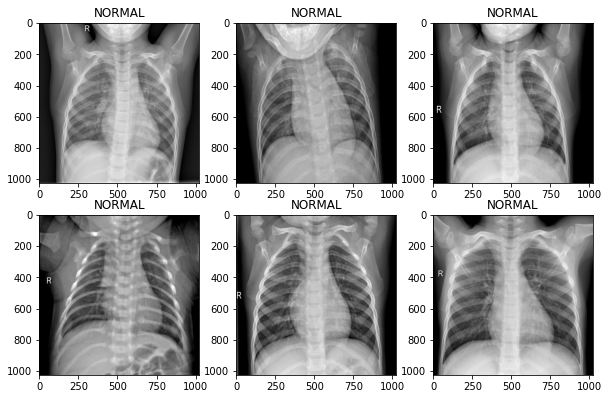

In [ ]:
plt.figure(figsize=(10,10))
for i in range(6):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(train_dir + "/normal",normal_images[i])),cmap='gray')
    plt.title("NORMAL")
plt.show()

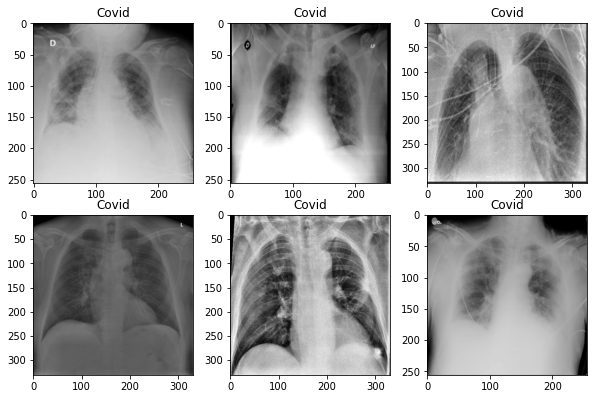

In [ ]:
plt.figure(figsize = (10,10))
for i in range(6) :
  plt.subplot(3,3,i+1)
  plt.imshow( plt.imread(os.path.join(train_dir + "/covid" , covid_images[i] ) ), cmap = 'gray') 
  plt.title('Covid')

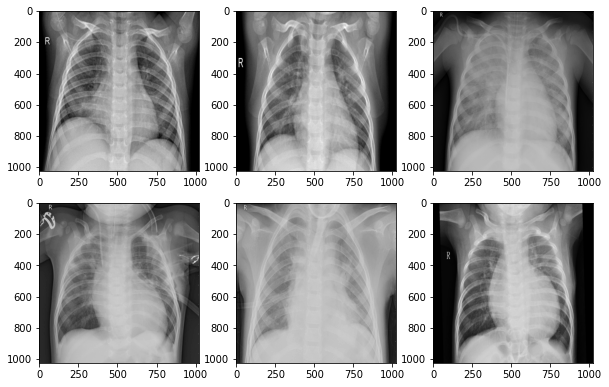

In [ ]:
plt.figure(figsize = (10,10))
for i in range(6) :
  plt.subplot(3,3 , i+1) 
  plt.imshow(plt.imread(os.path.join(train_dir + "/viral" , pneumonia_images[i]) ) , cmap ='gray')

Loading the images 

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255 , zoom_range = 0.2 , rotation_range= 20 , horizontal_flip = True , featurewise_center= True , featurewise_std_normalization= True) 
test_datagen = ImageDataGenerator(rescale = 1./255)

In [87]:
data_path = '/content/drive/MyDrive/COVID-19 Radiography Database'
training_set = train_datagen.flow_from_directory(data_path + '/train' ,
                                                 target_size = (224,224) ,
                                                 batch_size =16,
                                                 class_mode = 'categorical',
                                                 shuffle = True)
val_set = test_datagen.flow_from_directory(data_path + '/val' ,
                                           target_size = (224 , 224),
                                           batch_size = 16,
                                           class_mode = 'categorical',
                                           shuffle = True)
test_set = test_datagen.flow_from_directory(data_path + '/test' , 
                                            target_size= (224 , 224),
                                            batch_size = 16,  
                                            class_mode = 'categorical',
                                            shuffle = False)

Found 2724 images belonging to 3 classes.
Found 584 images belonging to 3 classes.
Found 582 images belonging to 3 classes.


In [ ]:
print("train batch ", training_set.__getitem__(0)[0].shape)
print("validation batch ", val_set.__getitem__(0)[0].shape)
print("test batch ", test_set.__getitem__(0)[0].shape)


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


train batch  (16, 224, 224, 3)
validation batch  (16, 224, 224, 3)
test batch  (16, 224, 224, 3)


In [ ]:
training_set.class_indices

{'covid': 0, 'normal': 1, 'viral': 2}

download densenet201,removing the top and freezing layers weights 

In [ ]:
densenet_base = tf.keras.applications.DenseNet201(input_shape= (224,224 , 3  ) , weights = 'imagenet' , include_top = False )
for layer in densenet_base.layers:
  layer.trainable = False

x = densenet_base.output
x = tf.keras.layers.AveragePooling2D(name = 'averagepooling2d_head')(x)
x = tf.keras.layers.Flatten(name = "flatten_head")(x)
x = tf.keras.layers.Dense(64, activation="relu", name="dense_head")(x)
x = tf.keras.layers.Dropout(0.5, name="dropout_head")(x)
model_out = tf.keras.layers.Dense(3, activation='softmax', name="predictions_head")(x)

dense201_model = Model(inputs = densenet_base.input, outputs = model_out )


In [10]:
# defining optimizer and loss function
# label smoothing https://towardsdatascience.com/what-is-label-smoothing-108debd7ef06?gi=c7bb677605c
def categorical_smooth_loss(y_true, y_pred, label_smoothing=0.1): 
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=label_smoothing)
    return loss
optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)

In [59]:
dense201_model.compile(optimizer = optimizer , loss = categorical_smooth_loss , metrics = ['accuracy'])
dense201_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_14 (ZeroPadding2 (None, 230, 230, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_14[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
# defining callbacks 
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, epsilon=0.0001, patience=3, verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [ ]:
fitting_history = model.fit_generator(training_set , validation_data = val_set ,callbacks=[lr_reduce , es_callback]  , epochs = 25)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/25
171/171 [==============================] - 1011s 6s/step - loss: 0.7418 - accuracy: 0.7661 - val_loss: 0.4347 - val_accuracy: 0.9452
Epoch 2/25
171/171 [==============================] - 73s 426ms/step - loss: 0.5128 - accuracy: 0.9066 - val_loss: 0.4189 - val_accuracy: 0.9435
Epoch 3/25
171/171 [==============================] - 74s 432ms/step - loss: 0.5007 - accuracy: 0.9069 - val_loss: 0.4288 - val_accuracy: 0.9469
Epoch 4/25
171/171 [==============================] - 73s 424ms/step - loss: 0.4836 - accuracy: 0.9196 - val_loss: 0.4135 - val_accuracy: 0.9452
Epoch 5/25
171/171 [==============================] - 72s 423ms/step - loss: 0.4500 - accuracy: 0.9466 - val_loss: 0.4268 - val_accuracy: 0.9435
Epoch 6/25
171/171 [==============================] - 73s 426ms/step - loss: 0.4434 - accuracy: 0.9409 - val_loss: 0.3998 - val_accuracy: 0.9589
Epoch 7/25
171/171 [==============================] - 73s 428ms/step - loss: 0.4651 - accuracy: 0.9353 - val_loss: 0.3897 - val_acc

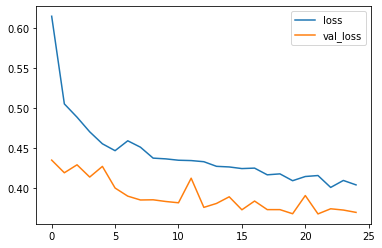

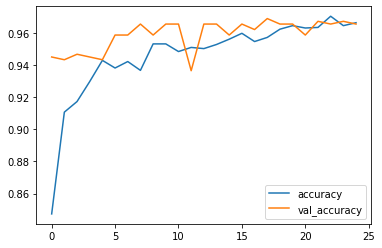

In [ ]:
import pandas as pd
history_frame = pd.DataFrame(fitting_history.history)
history_frame.loc[:,['loss','val_loss']].plot()
history_frame.loc[:,['accuracy','val_accuracy']].plot()

saving the model

In [ ]:
model.save('/content/drive/MyDrive/COVID-19 Radiography Database/covid_classifier_densenet201.h5')

loading the model

In [49]:
def LoadModel(ModelPath):
  from keras.models import load_model
  model = load_model(ModelPath, custom_objects={'categorical_smooth_loss': categorical_smooth_loss})
  print('model is loaded successfully ')
  return model

In [50]:
ModelPath = '/content/drive/MyDrive/COVID-19 Radiography Database/covid_classifier_densenet201.h5'
model = LoadModel(ModelPath)

model is loaded successfully 


### Those 2 functions tell us what features the model cared to them the most 

In [14]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap, top_pred_index.numpy()

    
# https://keras.io/examples/vision/grad_cam/
def superimposed_img(image, heatmap):
    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((image_size, image_size))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + image
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img

In [23]:
last_conv_layer_name = "conv5_block32_concat"
classifier_layer_names = [
    "bn",
    "relu",
    "averagepooling2d_head",
    "flatten_head",
    "dense_head",
    "dropout_head",
    "predictions_head"
]

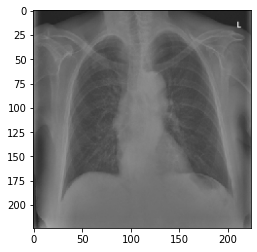

In [24]:
# test image
file_path =  '/content/drive/MyDrive/COVID-19 Radiography Database/test/covid/COVID (1006).png'
test_image = cv2.imread(file_path)
test_image = cv2.resize(test_image, (224,224),interpolation=cv2.INTER_NEAREST)
plt.imshow(test_image)
test_image = np.expand_dims(test_image,axis=0)

In [ ]:
heatmap, top_index = make_gradcam_heatmap(test_image, densenet_base, last_conv_layer_name, classifier_layer_names)
s_img = superimposed_img(test_image[0], heatmap)
plt.imshow(s_img)

ValueError: ignored

#### A function to display model performance on the test set

In [64]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

### testing the model accuracy on the test set

In [92]:
preds = model.predict_classes(test_set)
true_labels = test_set.classes

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


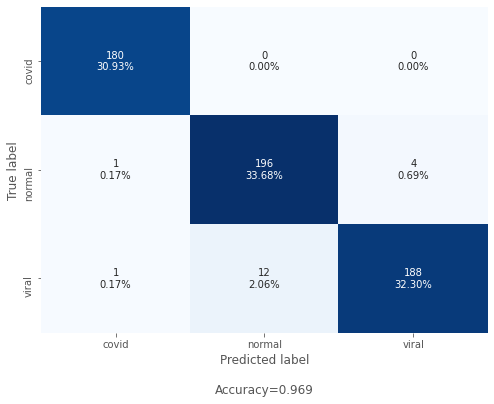

In [93]:
plt.style.use('ggplot')
cm = confusion_matrix(true_labels , preds)
make_confusion_matrix(cm  ,categories = ['covid' , 'normal', 'viral' ],figsize=(8,6), cbar=False)

We can see that the persicion of covid and viral are pretty good and also the model never predicted normal and it was actually covid (False negative) which i see in our case is the most critical situation we don't want it to happen.